### Empirical Study on the Least Square Monte Carlo Algorithm
The following items will be investigated:
- Choice of basis functions with benchmarking price
- Biasedness of LSM

The security used will be **Vanilla American Put**

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
# Generate paths
def GeometricBrownianMotion(T, nSteps, nPaths, X0, mu, sigma):
    dt = T/nSteps
    X = np.zeros((nPaths, nSteps))
    X[:,0] = X0
    for i in range(nSteps-1):
        X[:,i+1] = X[:,i] * np.exp((mu - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*np.random.randn(nPaths))
    return X

In [22]:
def get_coef(DCF, S_t, mode, deg):
    if mode == "polynomial": return np.polynomial.polynomial.polyfit(S_t, DCF, deg)
    elif mode == "laguerre": return np.polynomial.laguerre.lagfit(S_t, DCF, deg)
    elif mode == "chebyshev": return np.polynomial.chebyshev.chebfit(S_t, DCF, deg)
    elif mode == "hermite": return np.polynomial.hermite.hermfit(S_t, DCF, deg)
    return None

def get_approx(coefs, S_t, mode):
    if mode == "polynomial": return coefs[0] + np.polynomial.polynomial.Polynomial(coefs[1:])(S_t)
    elif mode == "laguerre": return coefs[0] + np.polynomial.laguerre.Laguerre(coefs[1:])(S_t)
    elif mode == "chebyshev": return coefs[0] + np.polynomial.chebyshev.Chebyshev(coefs[1:])(S_t)
    elif mode == "hermite": return coefs[0] + np.polynomial.hermite.Hermite(coefs[1:])(S_t)
    return None

class LSM:
    def __init__(self, r, dt, K, nPaths, nSteps, nTerms, mode):
        self.r = r
        self.dt = dt
        self.K = K
        self.nPaths = nPaths
        self.nSteps = nSteps
        self.nTerms = nTerms
        self.mode = mode
        self.coefs = [None] * nSteps
        
    # LSM to calculate the weights (train)
    def LSM_train(self, paths):
        exercise_time, DCF = np.empty(self.nPaths), np.empty(self.nPaths)
        exercise_time.fill(self.nSteps)
        DCF.fill(0)
        
        # Maturity Payoff
        for i in range(self.nPaths):
            if paths[i][-1] < self.K: DCF[i] = self.K - paths[i][-1]

        # backward induction
        for j in range(self.nSteps-2, 0, -1):
            
            # discount the DCF by one step
            DCF = DCF * np.exp(-self.r*self.dt)

            S_t = paths[:, j]
            exercise_val = np.clip(-S_t+self.K, 0, None)

            # only fit the ITM paths
            # obtain coefficients
            coefs = get_coef(DCF[np.where(exercise_val != 0)], S_t[np.where(exercise_val != 0)], self.mode, self.nTerms)
            self.coefs[j] = coefs
            
            # obtain approximated continuation value and update the DCF based on exercise value
            for i in range(self.nPaths):
                if exercise_val[i] > 0:
                    approx = get_approx(coefs, S_t[i], self.mode)
                    if exercise_val[i] > approx:
                        exercise_time[i] = j
                        DCF[i] = exercise_val[i]

    # LSM to calculate the option value (fit)
    def LSM_fit(self, paths):
        sum_vals = 0
        
        # forward pass to find the first exercise point
        for i in range(self.nPaths):
            exercised = False
            for j in range(1, self.nSteps-1):
                if self.K - paths[i][j] > 0 and self.K - paths[i][j] > get_approx(self.coefs[j], paths[i][j], self.mode):
                    sum_vals += (self.K - paths[i][j]) * np.exp(-self.r*self.dt*j)
                    exercised = True
                    break  # exercised !
            if not exercised:
                if self.K - paths[i][nSteps-1] > 0: sum_vals += (self.K - paths[i][nSteps-1]) * np.exp(-self.r*self.dt*(nSteps-1))
                    
        return sum_vals / self.nPaths

### Benchmarking Theoretical Price
Theoretical result retrieved in the paper from Longstaff and Schwartz.\
Target: American put with the parameters $S_0=44, \sigma=0.4, T=2, r=0.06, K=40$\
Benchmark price from finite difference method: $5.647$

In [37]:
polynomial = []
laguerre = []
chebyshev = []
hermite = []

S0, sigma, T, r, K = 44, 0.4, 2, 0.06, 40
nPaths = 50000
nSteps = 20
dt = T / nSteps

paths = GeometricBrownianMotion(T, nSteps, nPaths, S0, r, sigma)
paths2 = GeometricBrownianMotion(T, nSteps, nPaths, S0, r, sigma)
print("Completed path generation")

for deg in range(2, 10):
    LSM_polynomial = LSM(r, dt, K, nPaths, nSteps, deg, "polynomial")
    LSM_laguerre = LSM(r, dt, K, nPaths, nSteps, deg, "laguerre")
    LSM_chebyshev = LSM(r, dt, K, nPaths, nSteps, deg, "chebyshev")
    LSM_hermite = LSM(r, dt, K, nPaths, nSteps, deg, "hermite")
    
    LSM_polynomial.LSM_train(paths)
    LSM_laguerre.LSM_train(paths)
    LSM_chebyshev.LSM_train(paths)
    LSM_hermite.LSM_train(paths)
    
    polynomial.append(LSM_polynomial.LSM_fit(paths2))
    laguerre.append(LSM_laguerre.LSM_fit(paths2))
    chebyshev.append(LSM_chebyshev.LSM_fit(paths2))
    hermite.append(LSM_hermite.LSM_fit(paths2))
    
    print(f"Completed degree {deg}")

Completed path generation
Completed degree 2
Completed degree 3
Completed degree 4
Completed degree 5
Completed degree 6
Completed degree 7
Completed degree 8
Completed degree 9


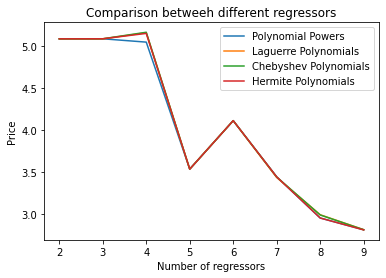

In [44]:
benchmark = [5.647] * 8
deg = list(range(2, 10))

# plot lines 
plt.plot(deg, polynomial, label = "Polynomial Powers") 
plt.plot(deg, laguerre, label = "Laguerre Polynomials") 
plt.plot(deg, chebyshev, label = "Chebyshev Polynomials")
plt.plot(deg, hermite, label = "Hermite Polynomials") 
plt.legend()
plt.title("Comparison betweeh different regressors")
plt.xlabel("Number of regressors")
plt.ylabel("Price")
plt.show()